In [15]:
import os

os.environ['OPENAI_API_KEY']=''
os.environ['LANGCHAIN_TRACING_V2']=''
os.environ['LANGCHAIN_ENDPOINT']=''
os.environ['LANGCHAIN_API_KEY']=''
os.environ['LANGCHAIN_PROJECT']=''

### Chroma

In [ ]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH10-VectorStores")

In [ ]:
# 샘플 데이터셋 로드
from langchain_community.document_loaders import TextLoader
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma


# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=0)

# 텍스트 파일을 load -> List[Document] 형태로 변환
loader1 = TextLoader("data/nlp-keywords.txt")
loader2 = TextLoader("data/finance-keywords.txt")

# 문서 분할
split_doc1 = loader1.load_and_split(text_splitter)
split_doc2 = loader2.load_and_split(text_splitter)

# 문서 개수 확인
len(split_doc1), len(split_doc2)

### VectorStore 생성
### 벡터 저장소 생성 (from_documents)
from_documents 클래스 메서드는 문서 리스트로부터 벡터 저장소를 생성합니다.

매개변수

- documents (List[Document]): 벡터 저장소에 추가할 문서 리스트
- embedding (Optional[Embeddings]): 임베딩 함수. 기본값은 None
- ids (Optional[List[str]]): 문서 ID 리스트. 기본값은 None
- collection_name (str): 생성할 컬렉션 이름.
- persist_directory (Optional[str]): 컬렉션을 저장할 디렉토리. 기본값은 None
- client_settings (Optional[chromadb.config.Settings]): Chroma 클라이언트 설정
- client (Optional[chromadb.Client]): Chroma 클라이언트 인스턴스
- collection_metadata (Optional[Dict]): 컬렉션 구성 정보. 기본값은 None

참고

- persist_directory가 지정되면 컬렉션이 해당 디렉토리에 저장됩니다. 지정되지 않으면 데이터는 메모리에 임시로 저장됩니다.
- 이 메서드는 내부적으로 from_texts 메서드를 호출하여 벡터 저장소를 생성합니다.
- 문서의 page_content는 텍스트로, metadata는 메타데이터로 사용됩니다.

반환값

- Chroma: 생성된 Chroma 벡터 저장소 인스턴스 생성시 documents 매개변수로 Document 리스트를 전달합니다. embedding 에 활용할 임베딩 모델을 지정하며, namespace 의 역할을 하는 collection_name 을 지정할 수 있습니다.

In [ ]:
# DB 생성
db = Chroma.from_documents(
    documents=split_doc1, embedding=OpenAIEmbeddings(), collection_name="my_db"
)

### persist_directory 지정시 disk 에 파일 형태로 저장합니다.

In [ ]:
# 저장할 경로 지정
DB_PATH = "./chroma_db"

# 문서를 디스크에 저장합니다. 저장시 persist_directory에 저장할 경로를 지정합니다.
persist_db = Chroma.from_documents(
    split_doc1, OpenAIEmbeddings(), persist_directory=DB_PATH, collection_name="my_db"
)

In [ ]:
# 디스크에서 문서를 로드합니다.
persist_db = Chroma(
    persist_directory=DB_PATH,
    embedding_function=OpenAIEmbeddings(),
    collection_name="my_db",
)

In [ ]:
# 저장된 데이터 확인
persist_db.get()

In [ ]:
# 디스크에서 문서를 로드합니다.
persist_db2 = Chroma(
    persist_directory=DB_PATH,
    embedding_function=OpenAIEmbeddings(),
    collection_name="my_db2",
)

# 저장된 데이터 확인
persist_db2.get()

### 벡터 저장소 생성 (from_texts)
from_texts 클래스 메서드는 텍스트 리스트로부터 벡터 저장소를 생성합니다.

매개변수

- texts (List[str]): 컬렉션에 추가할 텍스트 리스트
- embedding (Optional[Embeddings]): 임베딩 함수. 기본값은 None
- metadatas (Optional[List[dict]]): 메타데이터 리스트. 기본값은 None
- ids (Optional[List[str]]): 문서 ID 리스트. 기본값은 None
- collection_name (str): 생성할 컬렉션 이름. 기본값은 '_LANGCHAIN_DEFAULT_COLLECTION_NAME'
- persist_directory (Optional[str]): 컬렉션을 저장할 디렉토리. 기본값은 None
- client_settings (Optional[chromadb.config.Settings]): Chroma 클라이언트 설정
- client (Optional[chromadb.Client]): Chroma 클라이언트 인스턴스
- collection_metadata (Optional[Dict]): 컬렉션 구성 정보. 기본값은 None

참고

- persist_directory가 지정되면 컬렉션이 해당 디렉토리에 저장됩니다. 지정되지 않으면 데이터는 메모리에 임시로 저장됩니다.
- ids가 제공되지 않으면 UUID를 사용하여 자동으로 생성됩니다.

반환값

- 생성된 벡터 저장소 인스턴스

In [ ]:
# 문자열 리스트로 생성
db2 = Chroma.from_texts(
    ["안녕하세요. 정말 반갑습니다.", "제 이름은 테디입니다."],
    embedding=OpenAIEmbeddings(),
)

In [ ]:
# 데이터를 조회합니다.
db2.get()

### 유사도 검색
similarity_search 메서드는 Chroma 데이터베이스에서 유사도 검색을 수행합니다. 이 메서드는 주어진 쿼리와 가장 유사한 문서들을 반환합니다.

매개변수

- query (str): 검색할 쿼리 텍스트
- k (int, 선택적): 반환할 결과의 수. 기본값은 4입니다.
- filter (Dict[str, str], 선택적): 메타데이터로 필터링. 기본값은 None입니다.

참고

- k 값을 조절하여 원하는 수의 결과를 얻을 수 있습니다.
- filter 매개변수를 사용하여 특정 메타데이터 조건에 맞는 문서만 검색할 수 있습니다.
- 이 메서드는 점수 정보 없이 문서만 반환합니다. 점수 정보도 필요한 경우 similarity_search_with_score 
메서드를 직접 사용하세요.

반환값

- List[Document]: 쿼리 텍스트와 가장 유사한 문서들의 리스트

In [ ]:
db.similarity_search("TF IDF 에 대하여 알려줘")

In [ ]:
# k 값에 검색 결과의 개수를 지정할 수 있습니다.
db.similarity_search("TF IDF 에 대하여 알려줘", k=2)

In [ ]:
# filter 사용
db.similarity_search(
    "TF IDF 에 대하여 알려줘", filter={"source": "data/nlp-keywords.txt"}, k=2
)

### 벡터 저장소에 문서 추가
add_documents 메서드는 벡터 저장소에 문서를 추가하거나 업데이트합니다.

매개변수

- documents (List[Document]): 벡터 저장소에 추가할 문서 리스트
- **kwargs: 추가 키워드 인자
- ids: 문서 ID 리스트 (제공 시 문서의 ID보다 우선함)

참고

- add_texts 메서드가 구현되어 있어야 합니다.
- 문서의 page_content는 텍스트로, metadata는 메타데이터로 사용됩니다.
- 문서에 ID가 있고 kwargs에 ID가 제공되지 않으면 문서의 ID가 사용됩니다.
- kwargs의 ID와 문서 수가 일치하지 않으면 ValueError가 발생합니다.

반환값

- List[str]: 추가된 텍스트의 ID 리스트

예외

- NotImplementedError: add_texts 메서드가 구현되지 않은 경우 발생

In [ ]:
from langchain_core.documents import Document

# page_content, metadata, id 지정
db.add_documents(
    [
        Document(
            page_content="안녕하세요! 이번엔 도큐먼트를 새로 추가해 볼께요",
            metadata={"source": "mydata.txt"},
            id="1",
        )
    ]
)

In [ ]:
# id=1 로 문서 조회
db.get("1")

### add_texts 메서드는 텍스트를 임베딩하고 벡터 저장소에 추가합니다.

매개변수

- texts (Iterable[str]): 벡터 저장소에 추가할 텍스트 리스트
- metadatas (Optional[List[dict]]): 메타데이터 리스트. 기본값은 None
- ids (Optional[List[str]]): 문서 ID 리스트. 기본값은 None

참고

- ids가 제공되지 않으면 UUID를 사용하여 자동으로 생성됩니다.
- 임베딩 함수가 설정되어 있으면 텍스트를 임베딩합니다.
- 메타데이터가 제공된 경우:
- 메타데이터가 있는 텍스트와 없는 텍스트를 분리하여 처리합니다.
- 메타데이터가 없는 텍스트의 경우 빈 딕셔너리로 채웁니다.
- 컬렉션에 upsert 작업을 수행하여 텍스트, 임베딩, 메타데이터를 추가합니다.

반환값

- List[str]: 추가된 텍스트의 ID 리스트

예외

- ValueError: 복잡한 메타데이터로 인한 오류 발생 시, 필터링 방법 안내 메시지와 함께 발생 기존의 아이디에 추가하는 경우 upsert 가 수행되며, 기존의 문서는 대체됩니다.

In [ ]:
# 신규 데이터를 추가합니다. 이때 기존의 id=1 의 데이터는 덮어쓰게 됩니다.
db.add_texts(
    ["이전에 추가한 Document 를 덮어쓰겠습니다.", "덮어쓴 결과가 어떤가요?"],
    metadatas=[{"source": "mydata.txt"}, {"source": "mydata.txt"}],
    ids=["1", "2"],
)

In [ ]:
# id=1 조회
db.get(["1"])

### 벡터 저장소에서 문서 삭제
delete 메서드는 벡터 저장소에서 지정된 ID의 문서를 삭제합니다.

매개변수

- ids (Optional[List[str]]): 삭제할 문서의 ID 리스트. 기본값은 None

참고

- 이 메서드는 내부적으로 컬렉션의 delete 메서드를 호출합니다.
- ids가 None이면 아무 작업도 수행하지 않습니다.

반환값

- None

In [ ]:
# id 1 삭제
db.delete(ids=["1"])

In [ ]:
# 문서 조회
db.get(["1", "2"])

In [ ]:
# where 조건으로 metadata 조회
db.get(where={"source": "mydata.txt"})

### 초기화 

In [ ]:
# 컬렉션 초기화
db.reset_collection()

In [ ]:
# 초기화 후 문서 조회
db.get()

### 검색기(Retriever)

In [ ]:
# DB 생성 (split한 문서 db에 추가)
db = Chroma.from_documents(
    documents = split_doc1 + split_doc2,
    embedding = OpenAIEmbeddings(),
    collection_name = "nlp",
)

In [ ]:
retriever = db.as_retriever()
retriever.invoke("Word2Vec 에 대하여 알려줘")

In [ ]:
# mmr : 키워드를 가지고 유사도 검사/ similarity : 문장을 가지고 유사도 검사
retriever = db.as_retriever(
    search_type="mmr", search_kwargs={"k": 6, "lambda_mult": 0.25, "fetch_k": 10}
)
response = retriever.invoke("Word2Vec 에 대하여 알려줘")

In [ ]:
len(response)

In [ ]:
response.

### 유사도 threshold

In [ ]:
# 특정 임계값 이상의 유사도를 가진 문서만 검색 (0.8 이상의 문서만 검색)
retriever = db.as_retriever(
    search_type="similarity_score_threshold", search_kwargs={"score_threshold": 0.8}
)

In [ ]:
response = retriever.invoke("Word2Vec 에 대하여 알려줘")

In [ ]:
len(response)

In [ ]:
# 유사도 threshold(markdown)에서 첫번째 셀과 이 셀을 같이 실행하게 되면 에러는 발생하지 않지만 작동하지 않음
retriever = db.as_retriever(search_kwargs={"k": 1})

In [ ]:
# 특정 메타데이터 필터 적용 
retriever = db.as_retriever(
    search_kwargs={"filter": {"source": "data/finance-keywords.txt"}, "k": 2}
)
retriever.invoke("ESG 에 대하여 알려줘")

### 멀티모달 Retriever
- Multimodal Collection

In [1]:
!pip install -qU datasets

Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

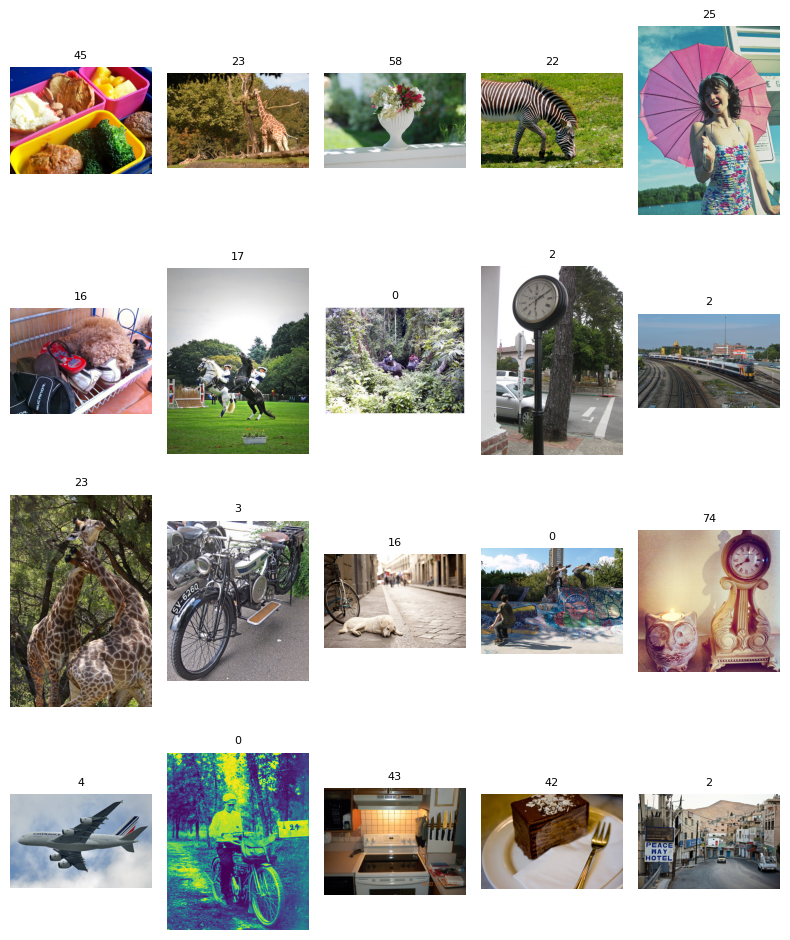

In [4]:
import os
from datasets import load_dataset
from matplotlib import pyplot as plt

# COCO 데이터셋 로드
dataset = load_dataset(
    path="detection-datasets/coco", name="default", split="train", streaming=True
)

# 이미지 저장 폴더와 이미지 개수 설정
IMAGE_FOLDER = "tmp"
N_IMAGES = 20

# 그래프 플로팅을 위한 설정
plot_cols = 5
plot_rows = N_IMAGES // plot_cols
fig, axes = plt.subplots(plot_rows, plot_cols, figsize=(plot_rows * 2, plot_cols * 2))
axes = axes.flatten()

# 이미지를 폴더에 저장하고 그래프에 표시
dataset_iter = iter(dataset)
os.makedirs(IMAGE_FOLDER, exist_ok=True)
for i in range(N_IMAGES):
    # 데이터셋에서 이미지와 레이블 추출
    data = next(dataset_iter)
    image = data["image"]
    label = data["objects"]["category"][0]  # 첫 번째 객체의 카테고리를 레이블로 사용

    # 그래프에 이미지 표시 및 레이블 추가
    axes[i].imshow(image)
    axes[i].set_title(label, fontsize=8)
    axes[i].axis("off")

    # 이미지 파일로 저장
    image.save(f"{IMAGE_FOLDER}/{i}.jpg")

# 그래프 레이아웃 조정 및 표시
plt.tight_layout()
plt.show()

In [5]:
!pip install -qU open-clip-torch

In [6]:
import open_clip
import pandas as pd

# 사용 가능한 모델/Checkpoint 를 출력
len(pd.DataFrame(open_clip.list_pretrained(), columns=["model_name", "checkpoint"]))

165

In [7]:
!pip install -qU langchain_experimental

In [9]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# OpenCLIP 임베딩 함수 객체 생성
image_embedding_function = OpenCLIPEmbeddings(
    model_name="ViT-H-14-378-quickgelu", checkpoint="dfn5b"
)

open_clip_pytorch_model.bin:   0%|          | 0.00/3.95G [00:00<?, ?B/s]

c:\Users\user\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--apple--DFN5B-CLIP-ViT-H-14-378. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [10]:
# 이미지의 경로를 리스트로 저장
image_uris = sorted(
    [
        os.path.join("tmp", image_name)
        for image_name in os.listdir("tmp")
        if image_name.endswith(".jpg")
    ]
)

image_uris

['tmp\\0.jpg',
 'tmp\\1.jpg',
 'tmp\\10.jpg',
 'tmp\\11.jpg',
 'tmp\\12.jpg',
 'tmp\\13.jpg',
 'tmp\\14.jpg',
 'tmp\\15.jpg',
 'tmp\\16.jpg',
 'tmp\\17.jpg',
 'tmp\\18.jpg',
 'tmp\\19.jpg',
 'tmp\\2.jpg',
 'tmp\\3.jpg',
 'tmp\\4.jpg',
 'tmp\\5.jpg',
 'tmp\\6.jpg',
 'tmp\\7.jpg',
 'tmp\\8.jpg',
 'tmp\\9.jpg']

In [11]:
!pip install -qU langchain_teddynote

In [20]:
# label 만드는 작업
from langchain_teddynote.models import MultiModal
from langchain_openai import ChatOpenAI

# ChatOpenAI 모델 초기화
llm = ChatOpenAI(model='gpt-4o-mini')

model = MultiModal(
    model=llm,
    system_prompt="Your mission is to describe the image in detail",  # 시스템 프롬프트: 이미지를 상세히 설명하도록 지시
    user_prompt="Description should be written in one sentence(less than 60 characters)",  # 사용자 프롬프트: 60자 이내의 한 문장으로 설명 요청
)

ImportError: cannot import name 'OpenAI' from 'openai' (c:\Users\user\anaconda3\Lib\site-packages\openai\__init__.py)

In [17]:
# 이미지 설명 생성
model.invoke(image_uris[0])

NameError: name 'model' is not defined

In [ ]:
# 이미지 설명
descriptions = dict()

for image_uri in image_uris:
    descriptions[image_uri] = model.invoke(image_uri, display_image=False)

# 생성된 결과물 출력
descriptions

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# 원본 이미지, 처리된 이미지, 텍스트 설명을 저장할 리스트 초기화
original_images = []
images = []
texts = []

# 그래프 크기 설정 (20x10 인치)
plt.figure(figsize=(20, 10))

# 'tmp' 디렉토리에 저장된 이미지 파일들을 처리
for i, image_uri in enumerate(image_uris):
    # 이미지 파일 열기 및 RGB 모드로 변환
    image = Image.open(image_uri).convert("RGB")

    # 4x5 그리드의 서브플롯 생성
    plt.subplot(4, 5, i + 1)

    # 이미지 표시
    plt.imshow(image)

    # 이미지 파일명과 설명을 제목으로 설정
    plt.title(f"{os.path.basename(image_uri)}\n{descriptions[image_uri]}", fontsize=8)

    # x축과 y축의 눈금 제거
    plt.xticks([])
    plt.yticks([])

    # 원본 이미지, 처리된 이미지, 텍스트 설명을 각 리스트에 추가
    original_images.append(image)
    images.append(image)
    texts.append(descriptions[image_uri])

# 서브플롯 간 간격 조정
plt.tight_layout()

In [ ]:
import numpy as np

# 이미지와 텍스트 임베딩
# 이미지 URI를 사용하여 이미지 특징 추출
img_features = image_embedding_function.embed_image(image_uris)
# 텍스트 설명에 "This is" 접두사를 추가하고 텍스트 특징 추출
text_features = image_embedding_function.embed_documents(
    ["This is " + desc for desc in texts]
)

# 행렬 연산을 위해 리스트를 numpy 배열로 변환
img_features_np = np.array(img_features)
text_features_np = np.array(text_features)

# 유사도 계산
# 텍스트와 이미지 특징 간의 코사인 유사도를 계산
similarity = np.matmul(text_features_np, img_features_np.T)

In [ ]:
# 유사도 행렬을 시각화하기 위한 플롯 생성
count = len(descriptions)
plt.figure(figsize=(20, 14))

# 유사도 행렬을 히트맵으로 표시
plt.imshow(similarity, vmin=0.1, vmax=0.3, cmap="coolwarm")
plt.colorbar()  # 컬러바 추가

# y축에 텍스트 설명 표시
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])  # x축 눈금 제거

# 원본 이미지를 x축 아래에 표시
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")

# 유사도 값을 히트맵 위에 텍스트로 표시
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

# 플롯 테두리 제거
for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

# 플롯 범위 설정
plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

# 제목 추가
plt.title("텍스트와 이미지 특징 간의 코사인 유사도", size=20)

### Vectorstore 생성 및 이미지 추가

In [ ]:
# DB 생성
image_db = Chroma(
    collection_name="multimodal",
    embedding_function=image_embedding_function,
)

# 이미지 추가
image_db.add_images(uris=image_uris)

In [ ]:
import base64
import io
from PIL import Image
from IPython.display import HTML, display
from langchain.schema import Document


class ImageRetriever:
    def __init__(self, retriever):
        """
        이미지 검색기를 초기화합니다.

        인자:
        retriever: LangChain의 retriever 객체
        """
        self.retriever = retriever

    def invoke(self, query):
        """
        쿼리를 사용하여 이미지를 검색하고 표시합니다.

        인자:
        query (str): 검색 쿼리
        """
        docs = self.retriever.invoke(query)
        if docs and isinstance(docs[0], Document):
            self.plt_img_base64(docs[0].page_content)
        else:
            print("검색된 이미지가 없습니다.")
        return docs

    @staticmethod
    def resize_base64_image(base64_string, size=(224, 224)):
        """
        Base64 문자열로 인코딩된 이미지의 크기를 조정합니다.

        인자:
        base64_string (str): 원본 이미지의 Base64 문자열.
        size (tuple): (너비, 높이)로 표현된 원하는 이미지 크기.

        반환:
        str: 크기가 조정된 이미지의 Base64 문자열.
        """
        img_data = base64.b64decode(base64_string)
        img = Image.open(io.BytesIO(img_data))
        resized_img = img.resize(size, Image.LANCZOS)
        buffered = io.BytesIO()
        resized_img.save(buffered, format=img.format)
        return base64.b64encode(buffered.getvalue()).decode("utf-8")

    @staticmethod
    def plt_img_base64(img_base64):
        """
        Base64로 인코딩된 이미지를 표시합니다.

        인자:
        img_base64 (str): Base64로 인코딩된 이미지 문자열
        """
        image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
        display(HTML(image_html))